In [1]:
import os
import random

In [2]:
import torch
import torchvision
from torch.nn import functional as F
from torch import nn
from pytorch_lightning.core.lightning import LightningModule
from pytorch_lightning import Trainer
from torch.optim import Adam
from torchvision.datasets import MNIST
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
import numpy as np
from nvidia.dali import pipeline_def
import nvidia.dali.fn as fn
import nvidia.dali.types as types
from nvidia.dali.plugin.pytorch import DALIClassificationIterator, DALIGenericIterator, LastBatchPolicy

In [4]:
videos_path = '/mnt/e/data/mnm/video'
bounding_boxes_path = '/mnt/e/data/mnm/annotations/my_data.csv'
cameras_path = '/mnt/e/data/mnm/annotations/my_camera.csv'

In [5]:
@pipeline_def
def video_pipe(filenames):
    videos, labels, start_frame_num, timestamps = fn.readers.video(
        device="gpu", 
        filenames=filenames, 
        labels=[],
        sequence_length=1,
        shard_id=0, 
        num_shards=1, 
        random_shuffle=True, 
        initial_fill=32,
        enable_frame_num=True,
        enable_timestamps=True,
        seed=22)
    return videos, labels, start_frame_num, timestamps

In [6]:
class MnmDataloader(DALIGenericIterator):
    def __init__(self, videos_path, bounding_boxes_path, cameras_path, batch_size=2, spatial_res=244, *kargs, **kvargs):

        video_files=[videos_path + '/' + f for f in os.listdir(videos_path)]

        pipe = video_pipe(
            batch_size=batch_size,
            num_threads=2,
            device_id=0,
            filenames=video_files,
            seed=123456)
            
        super().__init__(pipe, ['videos', 'labels', 'start_frame_num', 'timestamps'], *kargs, **kvargs)
        self.batch_size = batch_size
        self.spatial_res = spatial_res

        # load bbs
        self.bbs = pd.read_csv(bounding_boxes_path, header=None, dtype=int)*2
        self.cam = pd.read_csv(cameras_path, header=None, dtype=int).to_numpy()
        self.num_subjects = len(self.bbs.columns) // 7

    def _video_frame_to_annot_frame(self, video_frame_number):
        return round(video_frame_number * 20 / 29.97)

    def _get_bbs_for_video_frame(self, video_frame_number, cam_number, num_bbs=1):
        fn = self._video_frame_to_annot_frame(video_frame_number)
        subjects = np.where(self.cam[fn, :] == cam_number)[0].tolist()
        subjects = random.sample(subjects, num_bbs)

        print(f'fn= {fn}')

        bbs = []
        for s in subjects:
            bb = self.bbs.iloc[fn, s*4: s*4+4].to_list()
            bbs.append([bb[1], bb[0], bb[3], bb[2]])

        return bbs

    def __next__(self):
        out = super().__next__()
        # DDP is used so only one pipeline per process
        # also we need to transform dict returned by DALIClassificationIterator to iterable
        # and squeeze the lables
        # return out

        start_frames = out[0]['start_frame_num'].cpu()
        labels = out[0]['labels'].cpu()
        videos = out[0]['videos'].cpu().permute(0,1,4,2,3)

        out_videos = torch.empty((self.batch_size, 3, self.spatial_res, self.spatial_res), dtype=int)
        for i in range(self.batch_size):
            bb = self._get_bbs_for_video_frame(start_frames[i].item(), labels[i].item())[0]
            print(bb)
            out_videos[i] = torchvision.transforms.functional.resized_crop(videos[i].squeeze(), *bb, 
                size=[self.spatial_res, self.spatial_res])
        
        return {'videos': out_videos}
        out = out[0]
        return [out[k] if k != "label" else torch.squeeze(out[k]) for k in self.output_map]

In [7]:
dl = MnmDataloader(videos_path,bounding_boxes_path,cameras_path, batch_size=8)

[/opt/dali/dali/operators/reader/loader/video_loader.h:178] ``file_list_include_preceding_frame`` is set to False (or not set at all). In future releases, the default behavior would be changed to True.


In [8]:
samples = next(iter(dl))['videos']

fn= 28216
[326, 1276, 350, 486]
fn= 29993
[874, 948, 200, 222]
fn= 21985
[0, 912, 358, 510]
fn= 4015
[932, 1272, 146, 220]
fn= 8067
[366, 160, 218, 330]
fn= 33231
[44, 1352, 230, 392]
fn= 3452
[354, 938, 342, 340]
fn= 15909
[376, 1154, 302, 496]


In [9]:
samples.shape

torch.Size([8, 3, 244, 244])

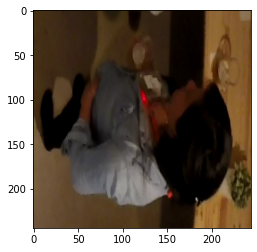

In [10]:
plt.imshow(samples[7,:,:,:].squeeze().permute(1,2,0))

torch.Size([2, 8, 1080, 1920, 3])

TypeError: list indices must be integers or slices, not tuple

[/opt/dali/dali/operators/reader/loader/video_loader.h:178] ``file_list_include_preceding_frame`` is set to False (or not set at all). In future releases, the default behavior would be changed to True.


IndexError: list index out of range

In [14]:
dl = DALIGenericIterator(video_pipe, ['videos', 'labels', 'start_frame_num', 'timestamps'])

AttributeError: 'function' object has no attribute 'max_batch_size'

In [ ]:
self.train_loader = LightningWrapper(mnist_pipeline, reader_name="Reader", last_batch_policy=LastBatchPolicy.PARTIAL, auto_reset=True)

In [ ]:
class (DataLoader):
    def __init__(self):
        super().__init__()
        self.train_loader = DALIClassificationIterator(
            video_pipe,
            reader_name="Reader",
            auto_reset=True)
    

In [38]:
pipe = video_pipe(batch_size=batch_size, num_threads=2, device_id=0, filenames=video_files, seed=123456)

In [39]:
pipe.build()

[/opt/dali/dali/operators/reader/loader/video_loader.h:178] ``file_list_include_preceding_frame`` is set to False (or not set at all). In future releases, the default behavior would be changed to True.


In [44]:
res = pipe.run()

In [46]:
all_res = []
for i in range(10):
    res = pipe.run()
    all_res.append(res[-2])

In [47]:
all_res

[TensorListGPU(
     [[ 4176]
      [21656]],
     dtype=DALIDataType.INT32,
     num_samples=2,
     shape=[(1,), (1,)]),
 TensorListGPU(
     [[22104]
      [ 4232]],
     dtype=DALIDataType.INT32,
     num_samples=2,
     shape=[(1,), (1,)]),
 TensorListGPU(
     [[ 4176]
      [21656]],
     dtype=DALIDataType.INT32,
     num_samples=2,
     shape=[(1,), (1,)]),
 TensorListGPU(
     [[22104]
      [ 4232]],
     dtype=DALIDataType.INT32,
     num_samples=2,
     shape=[(1,), (1,)]),
 TensorListGPU(
     [[ 4176]
      [21656]],
     dtype=DALIDataType.INT32,
     num_samples=2,
     shape=[(1,), (1,)]),
 TensorListGPU(
     [[22104]
      [ 4232]],
     dtype=DALIDataType.INT32,
     num_samples=2,
     shape=[(1,), (1,)]),
 TensorListGPU(
     [[ 4176]
      [21656]],
     dtype=DALIDataType.INT32,
     num_samples=2,
     shape=[(1,), (1,)]),
 TensorListGPU(
     [[22104]
      [ 4232]],
     dtype=DALIDataType.INT32,
     num_samples=2,
     shape=[(1,), (1,)]),
 TensorListGPU(


In [41]:
type(res)

tuple

TensorListGPU(
    [[ 9712]
     [16352]],
    dtype=DALIDataType.INT32,
    num_samples=2,
    shape=[(1,), (1,)])